# Imports.........
### I will use Transfer learning using pretrained Inception_v3 to detect faces

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D , BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py

In [35]:

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions

In [36]:

from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import keras

### Data is in .npz format, will use numpy to load this file

In [37]:
data = np.load("../input/ORL_faces.npz")

In [38]:
data.files

['testY', 'testX', 'trainX', 'trainY']

### Extract train and test data from list of arrays
- It contains four arrays

In [39]:
train_X, train_Y, test_X, test_Y = data['trainX'], data['trainY'], data['testX'], data['testY']

In [40]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((240, 10304), (240,), (160, 10304), (160,))

#### Lets see what label contains

In [41]:
np.unique(train_Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint8)

#### So there are 20 classes of data means 20 different faces
#### There are 240 training data and 160 test data
- Lets see how images look like
- If we factor of 10304 = 112*92
- So we can resize image to 112*92

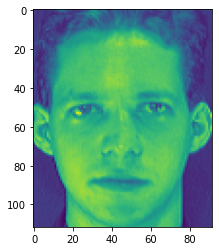

In [42]:
plt.imshow(train_X[0].reshape((112,92)))

#### lets transform images for our use
#### Image is in grey scale
#### Since Inception takes 3 dimention images so we will convert it to RGB

In [43]:
def transform_images(trainx, testx):
    trainx = trainx.astype('float32')  # CV2 image transformations works on float32 type of data
    testx = testx.astype('float32')
    new_train_X = []
    new_test_X = []
    for i in trainx:
        i = i/255.0   #  ----------------- ----------------------------------- Normalize image 
        i=cv2.cvtColor(i.reshape((112,92,1)),cv2.COLOR_GRAY2BGR) #------------ convert from gray to RGB 
        new_train_X.append(i)
    for j in testx:
        j = j/255.0
        j=cv2.cvtColor(j.reshape((112,92,1)),cv2.COLOR_GRAY2BGR)
        new_test_X.append(j)
    return np.array(new_train_X), np.array(new_test_X)
    

In [44]:
trainxx , testxx = transform_images(train_X, test_X)

In [45]:
trainxx[0].shape

(112, 92, 3)

### Image after converting to RGB

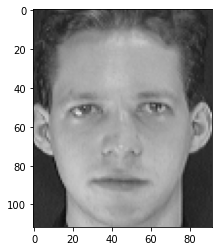

In [46]:
plt.imshow(trainxx[0])

## Define the inception model
### I have added 3 conv2d layer with Maxpooling2d and dropout layer

In [47]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(112, 92, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    
    conv_out1 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(model.output)
    drop1 = keras.layers.Dropout(.3)(conv_out1)
    pooled_out1 = keras.layers.MaxPooling2D((2,2),  padding='same')(drop1)
    conv_out2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pooled_out1)
    drop2 = keras.layers.Dropout(.1)(conv_out2)
    pooled_out2 = keras.layers.MaxPooling2D((1,1),  padding='same')(drop2)
    conv_out3 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pooled_out2)
    drop3 = keras.layers.Dropout(.1)(conv_out3)
    pooled_out3 = keras.layers.MaxPooling2D((1,1),  padding='same')(drop3)
    #conv_out4 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pooled_out3)
    #drop4 = keras.layers.Dropout(.1)(conv_out4)
    #pooled_out4 = keras.layers.MaxPooling2D((1,1),  padding='same')(drop4)
    
    reshape_layer = keras.layers.Flatten()(pooled_out3)
    #new_output = keras.layers.GlobalAveragePooling2D(32)(model.output)
    
    #pooled_out = keras.layers.MaxPooling2D((2,2),  padding='same')(new_output)
    # add new dense layer for our labels
    #new_output = keras.layers.Dense(256, activation='relu')(reshape_layer)
    new_output = keras.layers.Dense(20, activation='softmax')(reshape_layer)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [48]:
#--------------------------------- Instantiate model
#--------------------------------- It will download the weights


model = inception()

In [49]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 112, 92, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 55, 45, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 55, 45, 32)   96          conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 55, 45, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

Total params: 24,274,228
Trainable params: 24,239,796
Non-trainable params: 34,432
__________________________________________________________________________________________________


# We will use previous Inception_v3 weights and add CNN and dense layers on top of that

### #  This for loop is to disable or enable last few layers for fine tuining
### -1 means no layer is fine tuned
### in first for loop i am Fine tuning only batch normalization layer 


In [50]:
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)

for layer in model.layers[:-1]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

### Lets compile the model
#### if we use categorical_crossentropy then we have to one hot encode our label to have 20 dimentions instead of 1
#### So using sparse_categorical_entropy

In [51]:

model.compile(
    loss='sparse_categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.Adam(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

### Create Callbacks for Saving best models and implementing early stopping

In [52]:
filepath="best_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, EarlyStopping(patience = 10)]

### Fit and Train

In [53]:
#model.fit(trainxx.reshape((240,112,92,1)), train_Y.reshape((train_Y.shape[0],1)), verbose=2, validation_split= .2)
model.fit(trainxx, train_Y, batch_size= 20, epochs=100, callbacks= callbacks_list, verbose=2, validation_data= (testxx, test_Y))

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.06250, saving model to best_models/weights-improvement-01-0.06.hdf5
12/12 - 2s - loss: 3.0026 - accuracy: 0.0167 - val_loss: 2.9946 - val_accuracy: 0.0625
Epoch 2/100

Epoch 00002: val_accuracy did not improve from 0.06250
12/12 - 1s - loss: 2.9959 - accuracy: 0.0417 - val_loss: 2.9975 - val_accuracy: 0.0625
Epoch 3/100

Epoch 00003: val_accuracy did not improve from 0.06250
12/12 - 1s - loss: 2.9906 - accuracy: 0.0458 - val_loss: 2.9966 - val_accuracy: 0.0625
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.06250 to 0.08125, saving model to best_models/weights-improvement-04-0.08.hdf5
12/12 - 1s - loss: 2.9881 - accuracy: 0.0625 - val_loss: 2.9931 - val_accuracy: 0.0812
Epoch 5/100

Epoch 00005: val_accuracy did not improve from 0.08125
12/12 - 1s - loss: 2.9822 - accuracy: 0.1042 - val_loss: 2.9865 - val_accuracy: 0.0688
Epoch 6/100

Epoch 00006: val_accuracy improved from 0.08125 to 0.08750, saving model to best_mo

Epoch 42/100

Epoch 00042: val_accuracy did not improve from 0.79375
12/12 - 1s - loss: 0.8582 - accuracy: 0.7792 - val_loss: 1.0373 - val_accuracy: 0.7812
Epoch 43/100

Epoch 00043: val_accuracy did not improve from 0.79375
12/12 - 1s - loss: 0.8245 - accuracy: 0.8000 - val_loss: 1.0024 - val_accuracy: 0.7875
Epoch 44/100

Epoch 00044: val_accuracy did not improve from 0.79375
12/12 - 1s - loss: 0.7689 - accuracy: 0.8125 - val_loss: 0.9914 - val_accuracy: 0.7688
Epoch 45/100

Epoch 00045: val_accuracy did not improve from 0.79375
12/12 - 1s - loss: 0.7262 - accuracy: 0.8250 - val_loss: 0.9045 - val_accuracy: 0.7937
Epoch 46/100

Epoch 00046: val_accuracy improved from 0.79375 to 0.83750, saving model to best_models/weights-improvement-46-0.84.hdf5
12/12 - 1s - loss: 0.6560 - accuracy: 0.8333 - val_loss: 0.8731 - val_accuracy: 0.8375
Epoch 47/100

Epoch 00047: val_accuracy did not improve from 0.83750
12/12 - 1s - loss: 0.6492 - accuracy: 0.8583 - val_loss: 0.8531 - val_accuracy: 0.837

Epoch 91/100

Epoch 00091: val_accuracy did not improve from 0.96875
12/12 - 1s - loss: 0.1461 - accuracy: 0.9708 - val_loss: 0.2432 - val_accuracy: 0.9625
Epoch 92/100

Epoch 00092: val_accuracy did not improve from 0.96875
12/12 - 1s - loss: 0.1883 - accuracy: 0.9667 - val_loss: 0.2170 - val_accuracy: 0.9563
Epoch 93/100

Epoch 00093: val_accuracy improved from 0.96875 to 0.97500, saving model to best_models/weights-improvement-93-0.98.hdf5
12/12 - 1s - loss: 0.1263 - accuracy: 0.9875 - val_loss: 0.1980 - val_accuracy: 0.9750
Epoch 94/100

Epoch 00094: val_accuracy improved from 0.97500 to 0.98125, saving model to best_models/weights-improvement-94-0.98.hdf5
12/12 - 1s - loss: 0.1881 - accuracy: 0.9667 - val_loss: 0.1684 - val_accuracy: 0.9812
Epoch 95/100

Epoch 00095: val_accuracy did not improve from 0.98125
12/12 - 1s - loss: 0.1650 - accuracy: 0.9542 - val_loss: 0.1838 - val_accuracy: 0.9750
Epoch 96/100

Epoch 00096: val_accuracy did not improve from 0.98125
12/12 - 1s - loss: 

In [54]:
hist = model.history

### Min losses and Max accuracies achieved

In [67]:
print("min loss train", min(hist.history["loss"]))
print("min loss Validation", min(hist.history["val_loss"]))
print("max accuracy train", max(hist.history["accuracy"]))
print("max accuracy Validation", max(hist.history["val_accuracy"]))

min loss train 0.11938443034887314
min loss Validation 0.15274792909622192
max accuracy train 0.9916666746139526
max accuracy Validation 0.981249988079071


## Plotting...........................

#### plot train loss

Text(0, 0.5, 'loss')

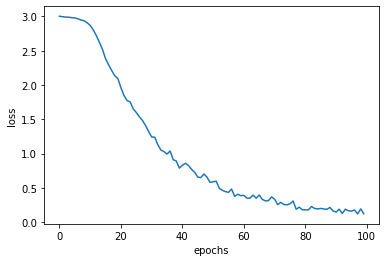

In [56]:
plt.plot(hist.history["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

#### plot validation loss

Text(0, 0.5, 'val_loss')

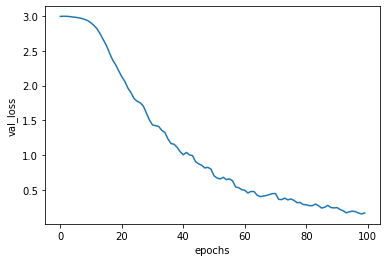

In [58]:
plt.plot(hist.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("val_loss")

#### plot train Accuracy

Text(0, 0.5, 'Accuracy')

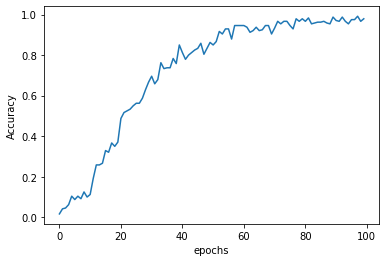

In [60]:
plt.plot(hist.history["accuracy"])
plt.xlabel("epochs")
plt.ylabel("Accuracy")

#### plot Validation Accuracy

Text(0, 0.5, 'val_accuracy')

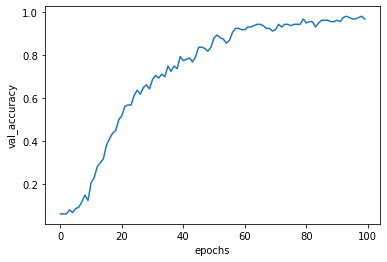

In [62]:
plt.plot(hist.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("val_accuracy")